In [ ]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings

style.use("seaborn-white")
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

### First part

In [ ]:
# functions to analyze 
def cubic(x):
    return x**3

def module(x):
    return abs(x - 0.2)

def x_sin(x):
    return x * np.sin(1/x)

In [ ]:
# search functions
def exhaustive_search(f, f_range=(0,1), eps=0.001):
    f_min = np.inf
    f_calculations = 0
    idx_min = None
    steps = np.arange(f_range[0], f_range[1], eps)
    for i in steps:
        cur_f = f(i)
        if f_min > cur_f:
            f_min = cur_f
            idx_min = i
        f_calculations += 1
    return idx_min, f_min, f_calculations, len(steps) 

def dichotomy_search(f, f_range=(0,1), eps=0.001):
    delta = eps * 0.5
    a, b = f_range
    f_calculations = 0
    iters = 0
    while abs(a-b) >= eps:
        x1, x2 = (a+b-delta) / 2, (a+b+delta) / 2
        if f(x1) <= f(x2):
            b = x2
        else:
            a = x1
        f_calculations += 2
        iters += 1
    return (a+b) / 2, f((a+b) / 2), f_calculations + 1, iters

def golden_section(f, f_range=(0,1), eps=0.001):
    delta = (3 - np.sqrt(5)) / 2
    f_calculations = 0
    a, b = f_range
    x1, x2 = a + delta * (b-a), b - delta * (b-a)
    f_x1, f_x2 = f(x1), f(x2)
    f_calculations += 2
    iters = 0
    while abs(a-b) >= eps:
        if f_x1 <= f_x2:
            b = x2
            x2 = x1
            x1 = a + delta * (b-a)
            f_x2 = f_x1
            f_x1 = f(x1)
        else:
            a = x1
            x1 = x2
            x2 = b - delta * (b-a)
            f_x1 = f_x2
            f_x2 = f(x2)
        f_calculations += 1
        iters += 1
    return (a+b) / 2, f((a+b) / 2), f_calculations + 1, iters

In [ ]:
searches = (exhaustive_search, dichotomy_search, golden_section)

In [ ]:
def search_and_plot_results(f, f_range, f_true_min):
    results_calculations = dict()
    results_errors = dict()
    results_iters = dict()
    for search in searches:
        _, f_min, f_calculations, iters = search(f, f_range)
        results_calculations[search.__name__] = f_calculations
        results_errors[search.__name__] = abs(f_min - f_true_min)
        results_iters[search.__name__] = iters
    _, axes = plt.subplots(nrows=3, figsize=(12, 20))
    axes[0].bar(results_errors.keys(), results_errors.values(), log=True)
    axes[0].title.set_text(f"Searches errors (log scale), {f.__name__} function")
    axes[1].bar(results_iters.keys(), results_iters.values(), log=True, color='g')
    axes[1].title.set_text(f"Searches number of iterations (log scale), {f.__name__} function")
    axes[2].bar(results_calculations.keys(), results_calculations.values(), log=True, color='r')
    axes[2].title.set_text(f"Searches number of function calculations (log scale), {f.__name__} function")

In [ ]:
search_and_plot_results(cubic, (0, 1), 0)

In [ ]:
search_and_plot_results(module, (0, 1), 0)

In [ ]:
search_and_plot_results(x_sin, (0.01, 1), -0.217234)

### Second part (2D)

In [ ]:
def get_noisy_data():
    alpha, beta = np.random.uniform(size=2)
    x = np.arange(0, 1, 0.01)
    y = alpha * x + beta + np.random.normal(size=x.shape)
    return np.array([x, y])

def loss(f, x, a, b, y_true):
    return np.sum((f(x, a, b) - y_true) ** 2)

def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

In [ ]:
# 2d search methods
def exhaustive_2d_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    f_min = np.inf
    f_calculations = 0
    best_params = None
    iters = 0
    for i in np.arange(f_range_1[0], f_range_1[1], eps):
        for j in np.arange(f_range_2[0], f_range_2[1], eps):
            cur_loss = loss(f, x, i, j, y_true)
            if f_min > cur_loss:
                f_min = cur_loss
                best_params = (i, j)
            f_calculations += 1
            iters += 1
    return best_params[0], best_params[1], f_min, f_calculations, iters

def gauss_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    a, b = 0.5, 0.5
    loss_prev = loss(f, x, a, b, y_true)
    min_loss = np.inf
    f_calculations = 1
    iters = 0
    while abs(min_loss - loss_prev) >= eps:
        loss_prev = min_loss
        
        # 'a' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=t, b=b, y_true=y_true)
        a_opt, min_loss, a_calculations, a_iters = golden_section(opt_fn, f_range_1, eps=eps)
        a_prev = a
        a = a_opt
        
        # 'b' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=a, b=t, y_true=y_true)
        b_opt, min_loss, b_calculations, b_iters = golden_section(opt_fn, f_range_2, eps=eps)
        b_prev = b
        b = b_opt
        
        f_calculations += a_calculations + b_calculations
        iters += a_iters + b_iters
    return a, b, min_loss, f_calculations, iters

def nelder_mead(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    opt_fn = lambda t: loss(f, x=x, a=t[0], b=t[1], y_true=y_true)
    a0, b0 = 0.5, 0.5
    result = optimize.minimize(opt_fn, x0=[a0, b0], method="Nelder-Mead", 
                               bounds=[f_range_1, f_range_2], 
                               options={"xatol": eps, "fatol": eps}
    )
    return result.x[0], result.x[1], result.fun, result.nfev, result.nit

In [ ]:
searches_2d = (exhaustive_2d_search, gauss_search, nelder_mead)

In [ ]:
def search_2d_and_plot(f, data, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    results_calculations = dict()
    results_iters = dict()
    _, axes = plt.subplots(nrows=3, figsize=(20, 25))
    axes[0].scatter(data[0], data[1], label='data', c='b')
    axes[0].title.set_text(f"Searches results for {f.__name__} approximant")
    for search in searches_2d:
        best_a, best_b, f_min, f_calculations, iters = search(
            f=f, x=data[0], y_true=data[1], f_range_1=f_range_1, f_range_2=f_range_2, eps=eps
        )
        label = f'{search.__name__}, min_loss={round(f_min, 2)}'
        axes[0].plot(data[0], f(data[0], best_a, best_b), label=label, linewidth=2)
        results_calculations[search.__name__] = f_calculations
        results_iters[search.__name__] = iters
    axes[0].legend()
    axes[1].bar(results_iters.keys(), results_iters.values(), log=True)
    axes[1].title.set_text(f"Searches number of iterations for {f.__name__} approximant")
    axes[2].bar(results_calculations.keys(), results_calculations.values(), log=True)
    axes[2].title.set_text(f"Searches number of function calculations for {f.__name__} approximant")

In [ ]:
data = get_noisy_data()

In [ ]:
search_2d_and_plot(linear, data)

In [ ]:
search_2d_and_plot(rational, data, f_range_1=(-1,1), f_range_2=(-1,1))

### First part

In [104]:
# functions to analyze 
def cubic(x):
    return x**3

def module(x):
    return abs(x - 0.2)

def x_sin(x):
    return x * np.sin(1/x)

In [136]:
# search functions
def exhaustive_search(f, f_range=(0,1), eps=0.001):
    f_min = np.inf
    f_calculations = 0
    idx_min = None
    steps = np.arange(f_range[0], f_range[1], eps)
    for i in steps:
        cur_f = f(i)
        if f_min > cur_f:
            f_min = cur_f
            idx_min = i
        f_calculations += 1
    return idx_min, f_min, f_calculations, len(steps) 

def dichotomy_search(f, f_range=(0,1), eps=0.001):
    delta = eps * 0.5
    a, b = f_range
    f_calculations = 0
    iters = 0
    while abs(a-b) >= eps:
        x1, x2 = (a+b-delta) / 2, (a+b+delta) / 2
        if f(x1) <= f(x2):
            b = x2
        else:
            a = x1
        f_calculations += 2
        iters += 1
    return (a+b) / 2, f((a+b) / 2), f_calculations + 1, iters

def golden_section(f, f_range=(0,1), eps=0.001):
    delta = (3 - np.sqrt(5)) / 2
    f_calculations = 0
    a, b = f_range
    x1, x2 = a + delta * (b-a), b - delta * (b-a)
    f_x1, f_x2 = f(x1), f(x2)
    f_calculations += 2
    iters = 0
    while abs(a-b) >= eps:
        if f_x1 <= f_x2:
            b = x2
            x2 = x1
            x1 = a + delta * (b-a)
            f_x2 = f_x1
            f_x1 = f(x1)
        else:
            a = x1
            x1 = x2
            x2 = b - delta * (b-a)
            f_x1 = f_x2
            f_x2 = f(x2)
        f_calculations += 1
        iters += 1
    return (a+b) / 2, f((a+b) / 2), f_calculations + 1, iters

In [137]:
searches = (exhaustive_search, dichotomy_search, golden_section)

In [138]:
def search_and_plot_results(f, f_range, f_true_min):
    results_calculations = dict()
    results_errors = dict()
    results_iters = dict()
    for search in searches:
        _, f_min, f_calculations, iters = search(f, f_range)
        results_calculations[search.__name__] = f_calculations
        results_errors[search.__name__] = abs(f_min - f_true_min)
        results_iters[search.__name__] = iters
    _, axes = plt.subplots(nrows=3, figsize=(12, 20))
    axes[0].bar(results_errors.keys(), results_errors.values(), log=True)
    axes[0].title.set_text(f"Searches errors (log scale), {f.__name__} function")
    axes[1].bar(results_iters.keys(), results_iters.values(), log=True, color='g')
    axes[1].title.set_text(f"Searches number of iterations (log scale), {f.__name__} function")
    axes[2].bar(results_calculations.keys(), results_calculations.values(), log=True, color='r')
    axes[2].title.set_text(f"Searches number of function calculations (log scale), {f.__name__} function")

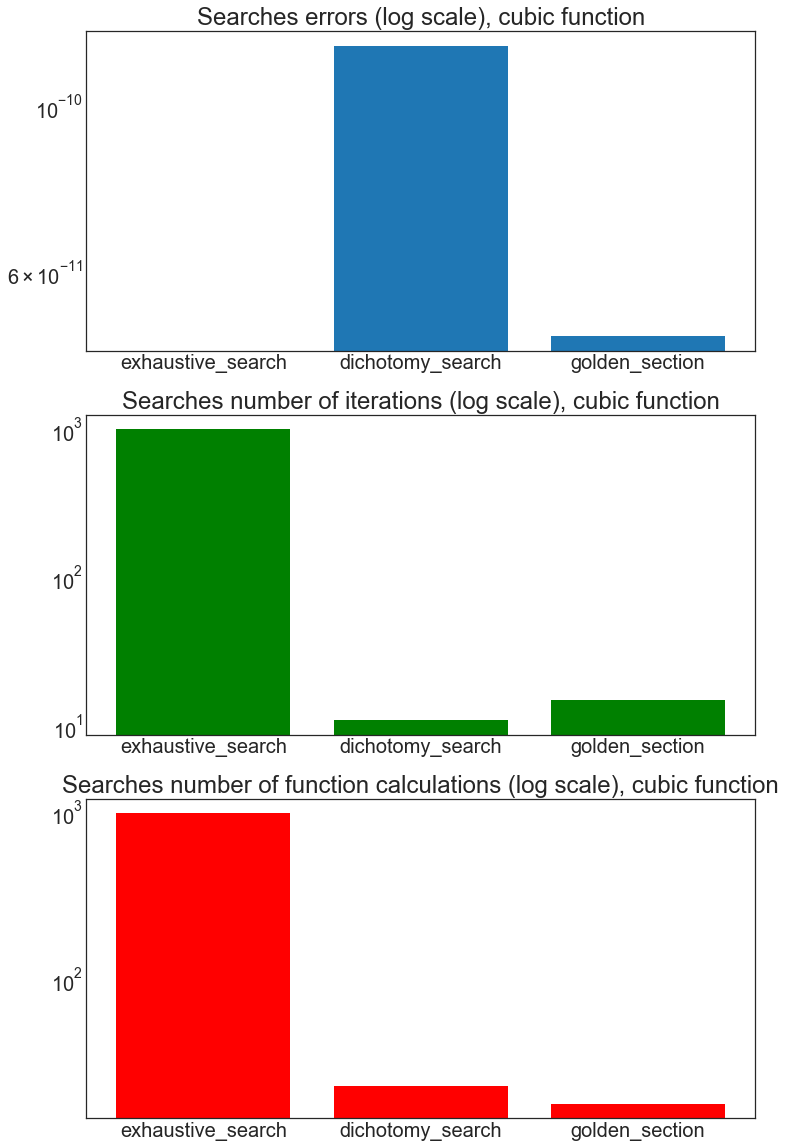

In [139]:
search_and_plot_results(cubic, (0, 1), 0)

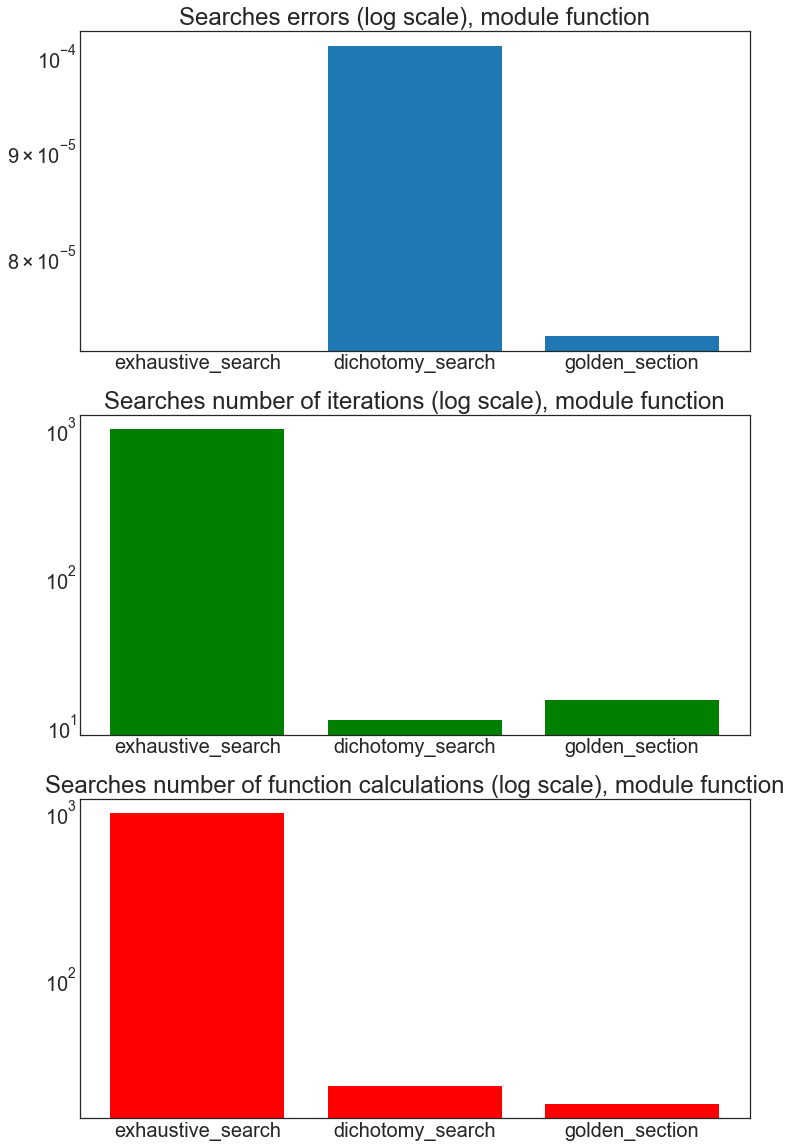

In [140]:
search_and_plot_results(module, (0, 1), 0)

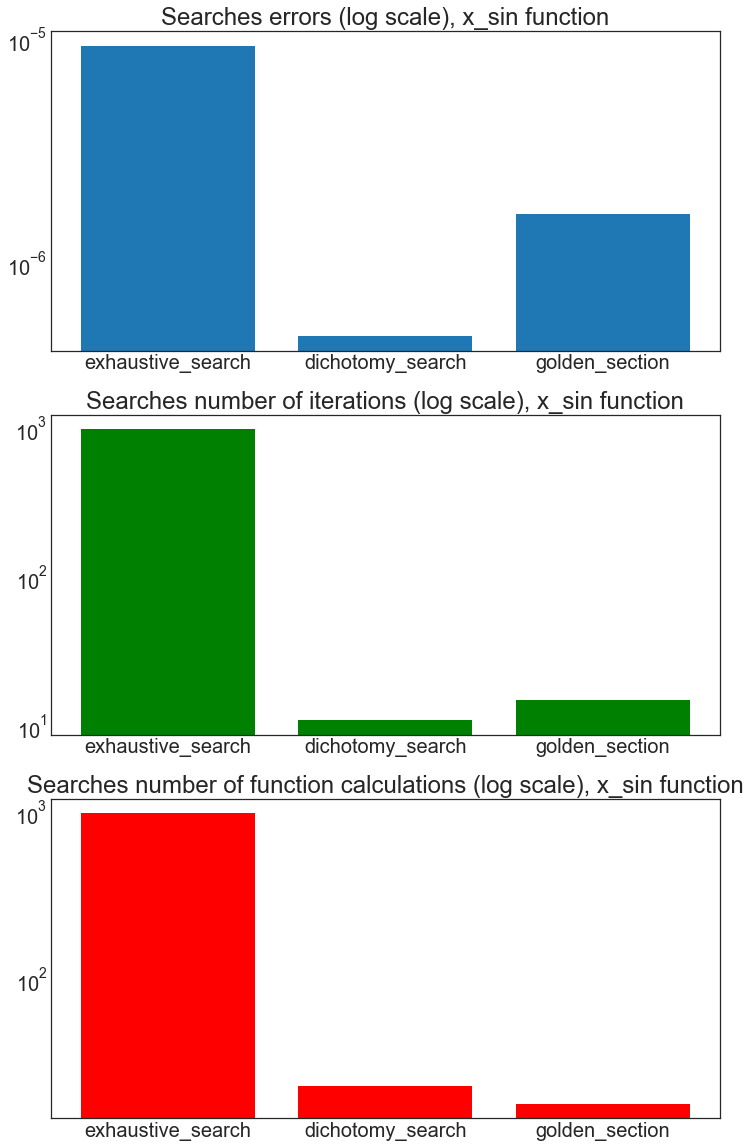

In [141]:
search_and_plot_results(x_sin, (0.01, 1), -0.217234)

### Second part (2D)

In [55]:
def get_noisy_data():
    alpha, beta = np.random.uniform(size=2)
    x = np.arange(0, 1, 0.01)
    y = alpha * x + beta + np.random.normal(size=x.shape)
    return np.array([x, y])

def loss(f, x, a, b, y_true):
    return np.sum((f(x, a, b) - y_true) ** 2)

def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

In [70]:
# 2d search methods
def exhaustive_2d_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    f_min = np.inf
    f_calculations = 0
    best_params = None
    iters = 0
    for i in np.arange(f_range_1[0], f_range_1[1], eps):
        for j in np.arange(f_range_2[0], f_range_2[1], eps):
            cur_loss = loss(f, x, i, j, y_true)
            if f_min > cur_loss:
                f_min = cur_loss
                best_params = (i, j)
            f_calculations += 1
            iters += 1
    return best_params[0], best_params[1], f_min, f_calculations, iters

def gauss_search(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    a, b = 0.5, 0.5
    loss_prev = loss(f, x, a, b, y_true)
    min_loss = np.inf
    f_calculations = 1
    iters = 0
    while abs(min_loss - loss_prev) >= eps:
        loss_prev = min_loss
        
        # 'a' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=t, b=b, y_true=y_true)
        a_opt, min_loss, a_calculations, a_iters = golden_section(opt_fn, f_range_1, eps=eps)
        a_prev = a
        a = a_opt
        
        # 'b' optimization
        opt_fn = lambda t: loss(f=f, x=x, a=a, b=t, y_true=y_true)
        b_opt, min_loss, b_calculations, b_iters = golden_section(opt_fn, f_range_2, eps=eps)
        b_prev = b
        b = b_opt
        
        f_calculations += a_calculations + b_calculations
        iters += a_iters + b_iters
    return a, b, min_loss, f_calculations, iters

def nelder_mead(f, x, y_true, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    opt_fn = lambda t: loss(f, x=x, a=t[0], b=t[1], y_true=y_true)
    a0, b0 = 0.5, 0.5
    result = optimize.minimize(opt_fn, x0=[a0, b0], method="Nelder-Mead", 
                               bounds=[f_range_1, f_range_2], 
                               options={"xatol": eps, "fatol": eps}
    )
    return result.x[0], result.x[1], result.fun, result.nfev, result.nit

In [98]:
searches_2d = (exhaustive_2d_search, gauss_search, nelder_mead)

In [149]:
def search_2d_and_plot(f, data, f_range_1=(0,1), f_range_2=(0,1), eps=0.001):
    results_calculations = dict()
    results_iters = dict()
    _, axes = plt.subplots(nrows=3, figsize=(20, 25))
    axes[0].scatter(data[0], data[1], label='data', c='b')
    axes[0].title.set_text(f"Searches results for {f.__name__} approximant")
    for search in searches_2d:
        best_a, best_b, f_min, f_calculations, iters = search(
            f=f, x=data[0], y_true=data[1], f_range_1=f_range_1, f_range_2=f_range_2, eps=eps
        )
        label = f'{search.__name__}, min_loss={round(f_min, 2)}'
        axes[0].plot(data[0], f(data[0], best_a, best_b), label=label, linewidth=2)
        results_calculations[search.__name__] = f_calculations
        results_iters[search.__name__] = iters
    axes[0].legend()
    axes[1].bar(results_iters.keys(), results_iters.values(), log=True)
    axes[1].title.set_text(f"Searches number of iterations for {f.__name__} approximant")
    axes[2].bar(results_calculations.keys(), results_calculations.values(), log=True)
    axes[2].title.set_text(f"Searches number of function calculations for {f.__name__} approximant")

In [146]:
data = get_noisy_data()

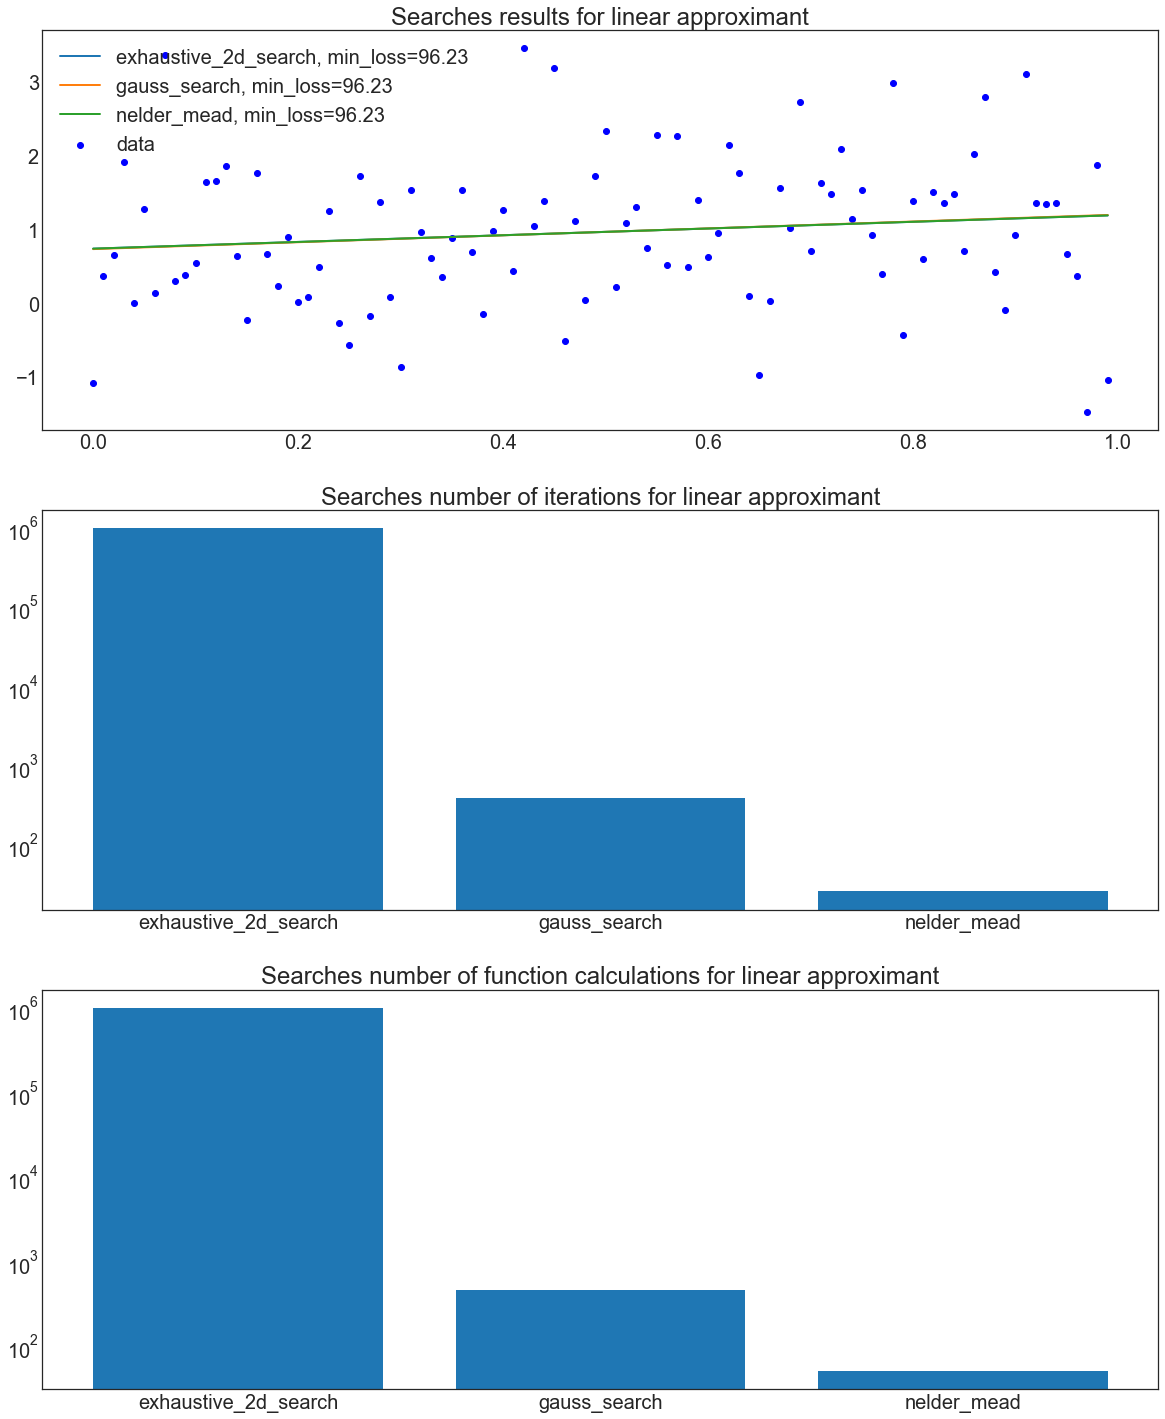

In [147]:
search_2d_and_plot(linear, data)

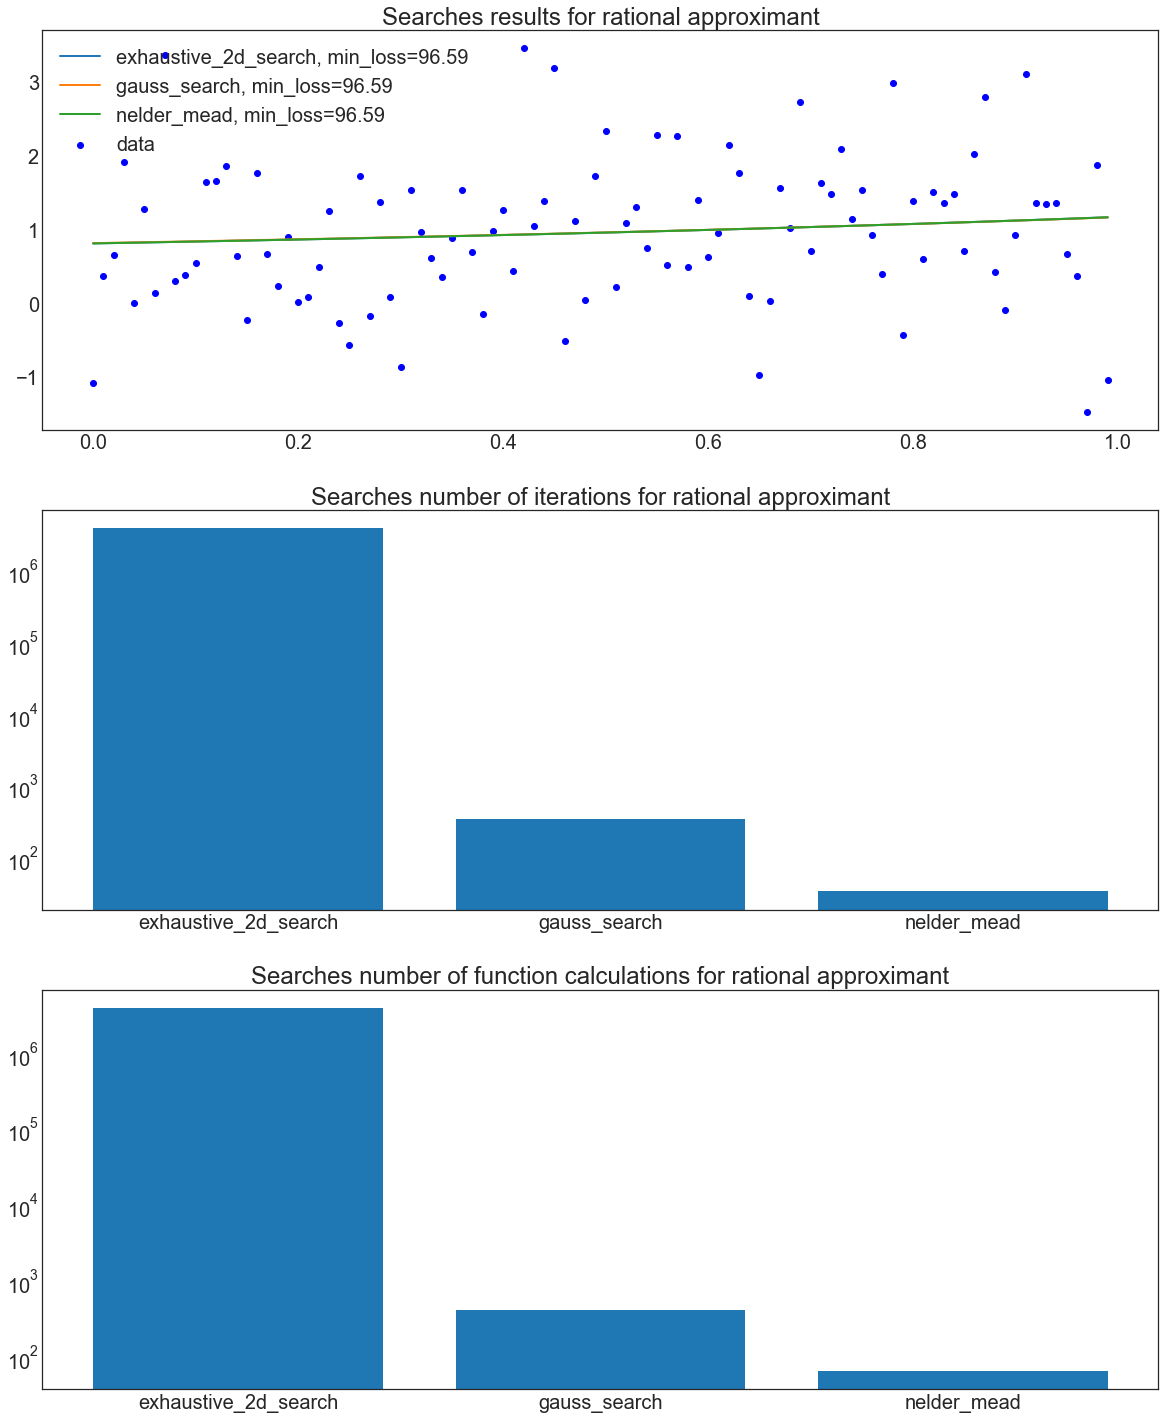

In [150]:
search_2d_and_plot(rational, data, f_range_1=(-1,1), f_range_2=(-1,1))